# Fitting the model to a galaxy

This tutorial will demonstrate how to fit a galaxy with the PANDISC package. The example is UGC 9037 (AGC 9037), the same galaxy as demonstrated in [Peng et al. 2023](https://ui.adsabs.harvard.edu/abs/2022arXiv221116455P/abstract). The spectral data is included in the example folder of the package.

To run this tutorial, three other packages are required, namely [emcee](https://github.com/dfm/emcee), [george](https://github.com/dfm/george), and [corner](https://github.com/dfm/corner.py).

First let's take a look at the data. From the ALFALFA table ([Haynes et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...861...49H/abstract)), we already know it is at heliocentric velocity 5939 km/s, and has a W50 = 294 km/s. 

In [26]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import pandisc
import emcee, george, corner

In [12]:
spec_table = fits.open("A009037.fits")[1].data
v, spec = spec_table["VHELIO"], spec_table["FLUX"]

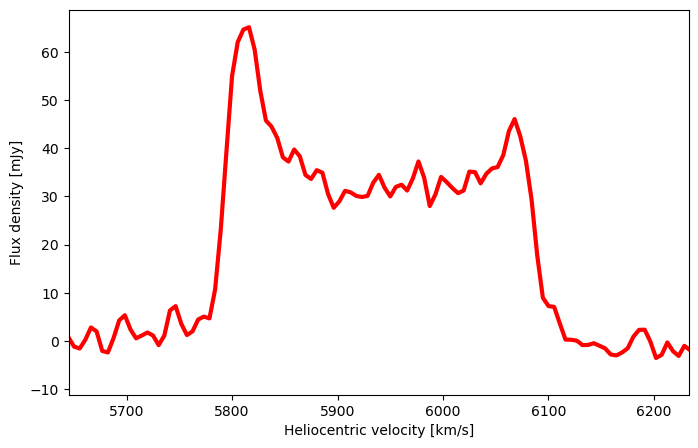

In [19]:
fig = plt.figure(figsize=(8, 5), dpi=100)
plt.plot(v, spec, 'r', label='spectrum', linewidth=3)
plt.xlim(5939-294, 5939+294)

plt.xlabel("Heliocentric velocity [km/s]"); plt.ylabel("Flux density [mJy]")
plt.show()

## Prepare for the fit

The fist step to prepare for the fit is to truncate the data. Because the evaluation of the model scales linearly as the input channel number, while most of the channels are blank. As an example we limit the fitted data to only channels within $v_c \pm W50$.

In [48]:
flag_fit = (v > 5939 - 294) & (v < 5939 + 294)
v_fit, spec_fit = v[flag_fit], spec[flag_fit]

We then construct the likelihood function. One function `ln_like()` is already included in the package, which uses the typical ALFALFA uncertainty $\sigma$=2.355 mJy to evaluate the likelihood of the fit. However, here we will use here a Gaussian process kernel (implemented in `george`) to construct a likelihood function that takes into account of the channel-wise correlation. By considering the correlated noise, the fitted results have bigger, but more statically robust uncertainties. Users are welcome to try the built-in `ln_like()` and compare the results.

In [22]:
def ln_like_kernel(para_mcmc, v_arr, spec_arr, gp_solver):
    if not gp_solver.computed:
        gp_solver.compute(v_arr)
    model_arr = pandisc.model_mcmc(para_mcmc, v_arr)
    return gp_solver.lnlikelihood(spec_arr - model_arr)

We also need to initialize a Gaussian process kernel. We use an exponential squared kernel, characterized by rms=2.23 ([Saintonge et al. 2007](https://ui.adsabs.harvard.edu/abs/2007AJ....133.2087S/abstract)), correlation across 3 channels, with each channel covering 5.1 km/s. But in many cases Matern32 kernel might be a better choice.

In [23]:
gp_solver = george.GP(
    2.23**2 * george.kernels.ExpSquaredKernel((3*5.1/2.355)**2), 
    solver=george.HODLRSolver)

We then finish with a probability function that combined the GP based likelihood function and the priori function built-in the package.

In [24]:
def ln_prob_kernel(para_mcmc, v_arr, spec_arr, gp_solver):
    lp = pandisc.ln_priori(para_mcmc, v_arr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like_kernel(para_mcmc, v_arr, spec_arr, gp_solver)

The next step is to set initial values for samplers. 

In [30]:
nwalkers, nstep = 128, 2000
ndim = 7
para = np.zeros((nwalkers, ndim))

para[:, 0] = np.log10(294/2 - 7) + (np.random.rand(nwalkers) - 0.5) * 0.05
para[:, 1] = 0 + np.random.rand(nwalkers) - 0.5
para[:, 2] = 10 + (np.random.rand(nwalkers) - 0.5) * 3
para[:, 3] = 0.8 + (np.random.rand(nwalkers) - 0.5) * 0.1
para[:, 4] = np.log10(min(100, 294/2)) + (np.random.rand(nwalkers) - 0.5) * 0.05
para[:, 5] = 11.51 * 1000 * (1 + 0.01*np.random.randn(nwalkers))  # mJy km/s
para[:, 6] = 5939 * (1 + 0.01*np.random.randn(nwalkers))

## MCMC fit

In [31]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, ln_prob_kernel, args=(v, spec, gp_solver))

In [33]:
state = sampler.run_mcmc(para, nstep, progress=True)

100%|███████████████████████████████████████| 2000/2000 [02:54<00:00, 11.46it/s]


In [34]:
samples = sampler.chain[:,-500:,:].reshape((-1, ndim))

As a simple the initial values cover a small range around the best, and the MCMC fit only runs for 200 steps without any additional setup. But in reality, the best fit values are not known, and multi-model distribution can exist for some unusual profiles. Thus when using it on a large sample of spectra with limited prior information, it is important to run multiple burn-in cycles with large coverage of initial values combined with large sampler step size, to ensure a complete sampling in the parameter space.

Let's check the fit result.

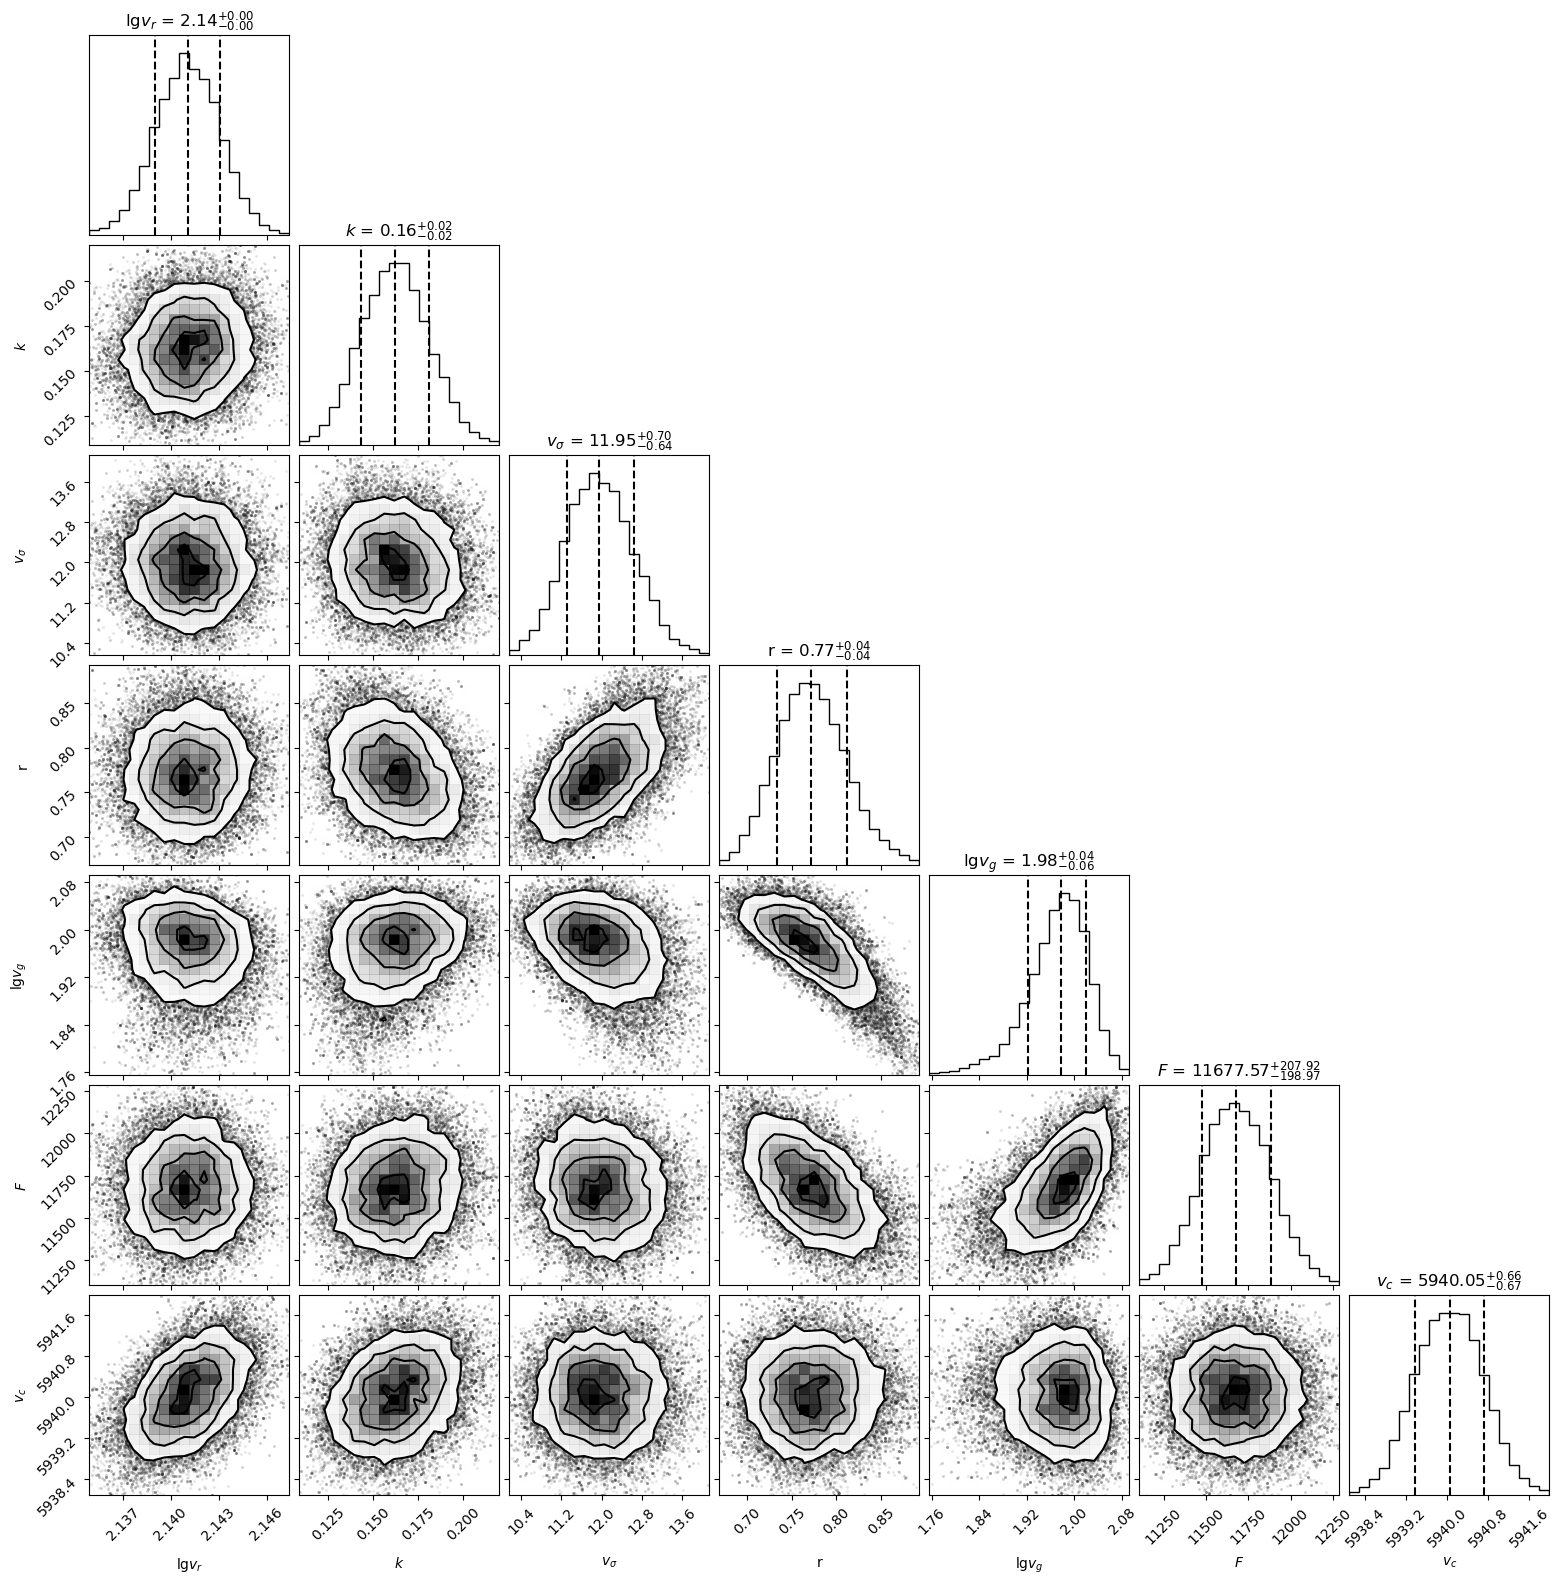

In [40]:
fig = corner.corner(samples, labels=
                    [r"$\lg v_r$", r"$k$", r"$ v_\sigma$", r"r", r"$\lg v_g$", 
                     r"$F$", r"$v_c$"], quantiles=(.1587, 0.5, .8413), 
                    show_titles=True, range=[0.997] * ndim)
plt.show()

The mdeian fitted values are

In [39]:
med_fit = np.percentile(samples, 50, axis=0).transpose()
print(med_fit)

[2.14107258e+00 1.62212832e-01 1.19486089e+01 7.70987965e-01
 1.97720967e+00 1.16775653e+04 5.94004998e+03]


We can plot the model corresponding to the median fit on top of the spectral data, along with 500 random draws from the posterior distribution.

In [50]:
med_disk, med_gaus = pandisc.model_mcmc_parts(med_fit, v_fit)

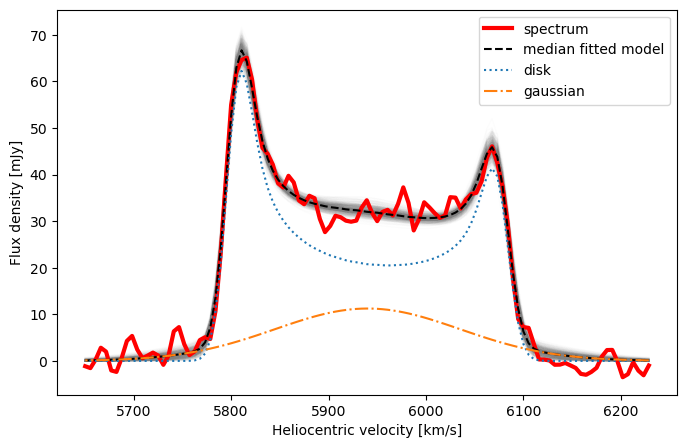

In [61]:
fig = plt.figure(figsize=(8, 5), dpi=100)
plt.plot(v_fit, spec_fit, 'r', label='spectrum', linewidth=3)
plt.plot(v_fit, (med_disk + med_gaus), 'k--', label="median fitted model")
plt.plot(v_fit, med_disk, ':', label="disk")
plt.plot(v_fit, med_gaus, '-.', label="gaussian")
for idx in np.random.choice(range(samples.shape[0]), 500):
    plt.plot(v_fit, pandisc.model_mcmc(samples[idx], v_fit), 
             'grey', alpha=.02, linewidth=1, zorder=0.5)

plt.xlabel("Heliocentric velocity [km/s]"); plt.ylabel("Flux density [mJy]")
plt.legend()
plt.show()

We can also check the residual after subtracting the median fitted model. The thick line highlights the residual of the channels used for fitting.

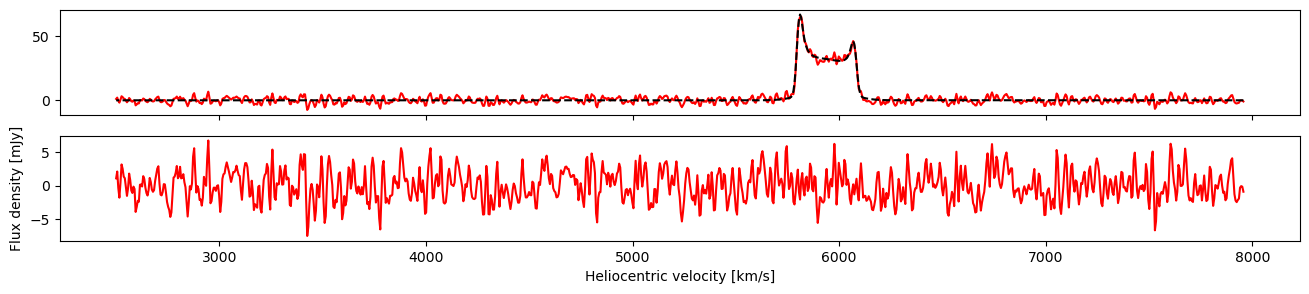

In [74]:
fig, axs = plt.subplots(2, 1, figsize=(16, 3), dpi=100, sharex=True)
ax = axs[0]
ax.plot(v, spec, "r", label='spectrum')
ax.plot(v, pandisc.model_mcmc(med_fit, v), "k--", label='median fit model')
ax = axs[1]
ax.plot(v, spec - pandisc.model_mcmc(med_fit, v), 'r', label='redisual')

plt.xlabel("Heliocentric velocity [km/s]"); plt.ylabel("Flux density [mJy]")
plt.show()